A template for plotting the data from multiple TDTR-measurements

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.data import beam, dataframe

#If the machine you are running the notebook on is incompatible with CUDA gpu computation, simply change this to import bidirectional
from src.analysis import bidirectional_gpu as bidirectional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

from scipy import optimize
plt.rcParams.update({'font.size' : 12})

import warnings
warnings.filterwarnings('ignore')

If running the notebook on your personal workstation, change the path to files to that of your local data directory

In [ ]:
path_to_files = r'../'

## Beam characterization

Finding the radii of the pump and probe beams, as well as plotting the intensities

(np.int64(1262), np.int64(1485))


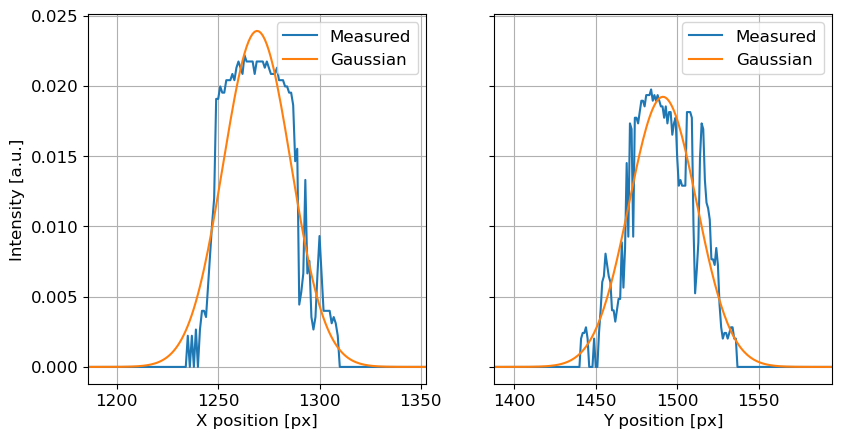

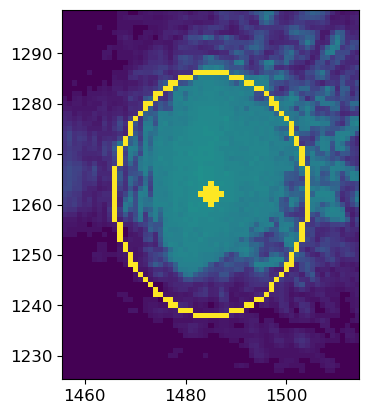

X-axis 1/e2 radius in um: 18.4
Y-axis 1/e2 radius in um: 22.8
Ellipticity: 0.740 (prolate)

Average 1/e2 radius (X radius + Y radius / 2): 20.6
(np.int64(1261), np.int64(1496))


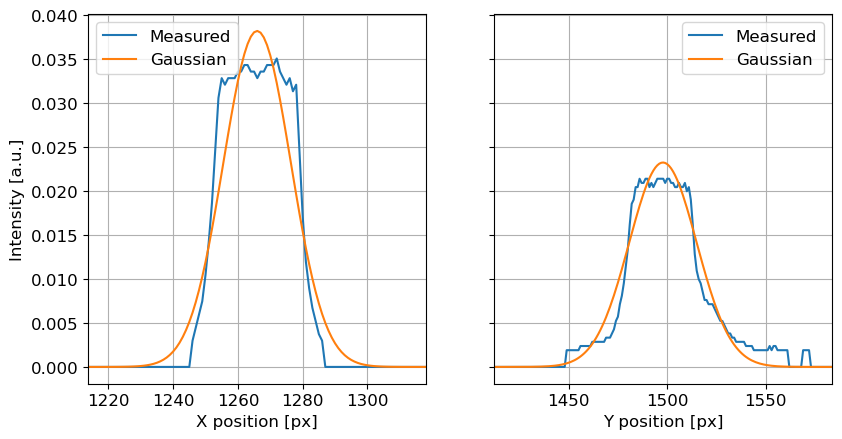

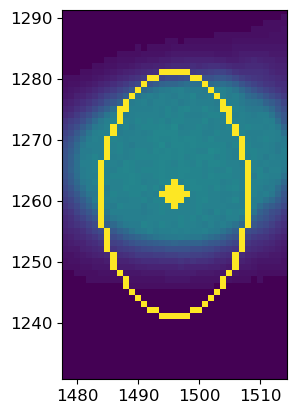

X-axis 1/e2 radius in um: 11.5
Y-axis 1/e2 radius in um: 18.9
Ellipticity: 1.305 (prolate)

Average 1/e2 radius (X radius + Y radius / 2): 15.2
Pump beam radius: 20.6 µm
Probe beam radius: 15.2 µm


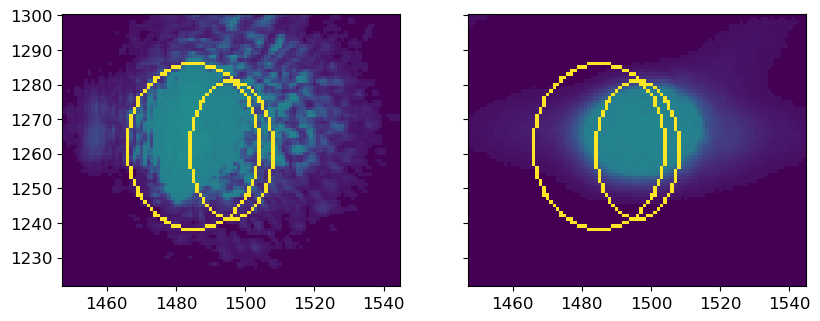

In [ ]:
r_pump, r_probe = beam.characterize_beam(
    red_beam  = r'../../beam/2025_08_01/probe.tif',
    blue_beam = r'../../beam/2025_08_01/pump.tif',
    plot = True, verbose = True, use_center = True
)

print('Pump beam radius: %.1f µm' % (r_pump * 1e6))
print('Probe beam radius: %.1f µm' % (r_probe * 1e6))

## Measurement results and picosecond acoustics

In [5]:
frequency = 6000e3

# Finding all the measurement data fitting the current measurement file pattern
file_list_unsorted = [f for f in pathlib.Path().glob("../../data/raw/AlN-M3-1001-S?-?*.mat")]

# Sorting the list by measurement name
file_list = sorted(file_list_unsorted, key=lambda p: p.name)

data_list = [dataframe.Measurement(file) for file in file_list]

# Lists for the shifted dataframe and picosecond acoustics objects
list_data_shift = []
list_t0_shift = []
list_picosecond_acoustics = []

#If a measurement was conducted without the picosecond acoustics, change the corresponding index to false
find_picosecond_acoustics = [True,True,True,True,True,True,True,True,True]

for i in range(0, len(data_list)):
     data = data_list[i]
    
     #Setting t0 based on the midpoint of the rising edge
     t0_shift = data.set_t0()

     #Adding phase shift to data so that V_out=constant around t_d=0
     data_shift = data.auto_phase_shift()

     #Plotting the measurement data in the given time delay region
     data_shift.plot(-20e-12, 100e-12)

     print('Sample ' + file_list[i].name)
     print('Data was shifted by %.1f degrees' % data.phase_sol)
     print('Phase uncertainties (del phase): %.2f degrees' % data.del_phase)
     SNR = data_shift.out_phase_statistics(plot = False, verbose = True)
     print('')

     list_t0_shift.append(t0_shift)
     list_data_shift.append(data_shift)
    
     if find_picosecond_acoustics[i] == True:
         #Finding the thickness of the aluminium transducer based on picosecond acoustics
         list_picosecond_acoustics.append(data_shift.picosecond_acoustics(h = 80e-9, use_ratio = True, plot = True) * 1e9)

In [6]:
#Default value for Al-transducer thickness is 80 nm, use this when picosecond acoustics is unreliable or unavailable
h_Al = 80

## Bidirectional fittings

In [ ]:
#Thickness of the sample
sample_thickness = 539.6718

In [ ]:
SystemParameters = bidirectional.SysParam(
    #Pump and probe radii, found from the beam characterization.
    r_pump  = r_pump,
    r_probe = r_probe,

    #Pump and probe intensities, default is 15 mW and 5 mW
    P_pump  = 15e-3,
    P_probe = 5e-3
)

SampleParameters = bidirectional.DutParam(
    #Initial guesses for the conductivities of the layers
    Lambda  = np.array([237, 0.15, 250, 0.1, 140]),
    #Layer lables
    Label   = ['Al', 'Al/AlN', 'AlN', 'AlN/Si', 'Si'],
    #If true, layer of material, if false, interface between two layers
    Layer   = [True, False, True, False, True],
    #Heat capacities of the layers
    C       = np.array([2.43, 0.1, 2.7, 0.1, 1.6]) * 1e6,
    #Thicknesses of the layers
    h       = np.array([h_Al, 1, sample_thickness, 1, 1e6]) * 1e-9,
)

### S1-1

Conducting the bidirectional fitting for a single measurement for the list, duplicate this set for all measurements

In [ ]:
#Change the index of the list for that of the correct measurement
data=list_data_shift[0]
name=file_list[0].name

Bidirectional = bidirectional.Bidirectional(SystemParameters)

Bidirectional.set_parameters(
    i_Lambda    = np.array([1, 2, 3]),
    i_C         = np.array([]),
    i_h         = np.array([]),

    #Time delay interval for bidirectional fitting, make sure the beginning is after the picosecond acoustics for reliable results
    tdelay_min  = 80e-12,
    tdelay_max  = 3000e-12
)
Bidirectional.set_sample_parameters(SampleParameters)
Bidirectional.add_measurement_data(frequency, data)

print('Measurement ' + name)

Sample AlN-M3-1001-S1-1@6000kHz_010825_110956.mat


CPU times: user 78.3 ms, sys: 9 μs, total: 78.3 ms
Wall time: 78.2 ms


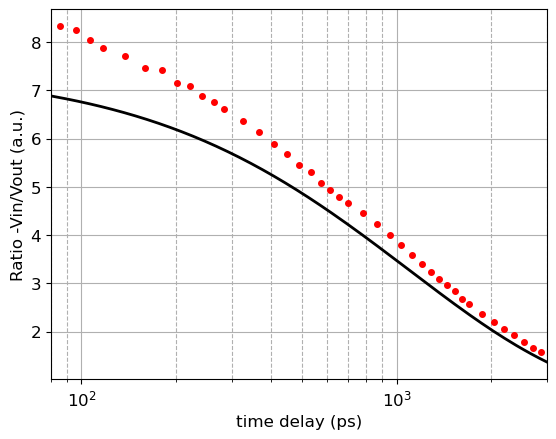

In [ ]:
%%time
Bidirectional.plot()

In [ ]:
%%time
OptRes = Bidirectional.fit(
    method  = 'Nelder-Mead', 
    bounds  = ((0, np.inf), (10, 1000), (0, np.inf)),
    plot    = False, verbose = True,
    fatol = 0.05, xatol = 0.5
)
# OptRes = Bidirectional.least_squares(
#     bounds = (optimize.Bounds(0.01, 1),
#               optimize.Bounds(0.5, 50), 
#               optimize.Bounds(0.01, 1)),
#     plot   = True, verbose = True
# )

Fitted thermal conductivities (W m^-1 K^-1): 
3. AlN: 123.24
Calculated (lambda / h) thermal conductances (MW m^-2 K^-1): 
2. Al/AlN: 187.71
4. AlN/Si: 362.75
CPU times: user 10.7 s, sys: 3.94 ms, total: 10.7 s
Wall time: 10.7 s


In [ ]:
OptRes

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.001623044792672695
             x: [ 1.877e-01  1.232e+02  3.628e-01]
           nit: 90
          nfev: 153
 final_simplex: (array([[ 1.877e-01,  1.232e+02,  3.628e-01],
                       [ 1.878e-01,  1.232e+02,  3.636e-01],
                       [ 1.877e-01,  1.236e+02,  3.618e-01],
                       [ 1.875e-01,  1.237e+02,  3.614e-01]]), array([ 1.623e-03,  1.623e-03,  1.623e-03,  1.623e-03]))

CPU times: user 78.5 ms, sys: 10 μs, total: 78.5 ms
Wall time: 78.4 ms


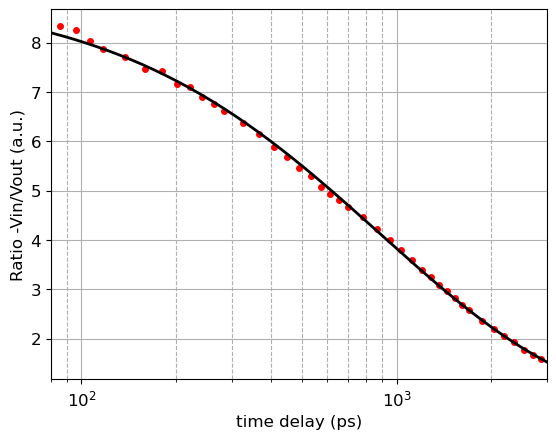

In [ ]:
%%time
Bidirectional.plot()

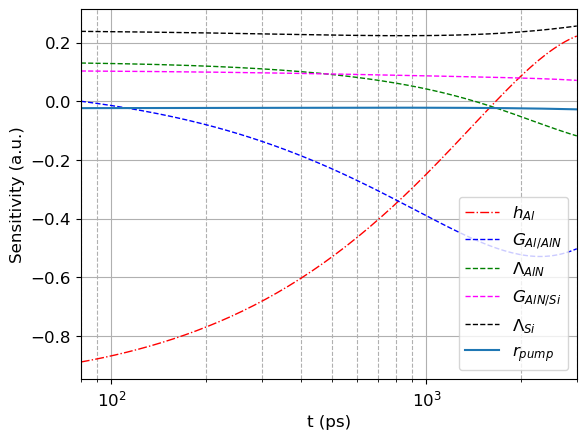

In [ ]:
S, Sx = Bidirectional.calculate_sensitivity()
Bidirectional.plot_sensitivity(S, i_C = [], i_h = [0], i_Lambda = [1, 2, 3, 4], 
                               legend_loc = 'lower right')

In [ ]:
Bidirectional = bidirectional.Bidirectional(SystemParameters)

Bidirectional.set_parameters(
    i_Lambda    = np.array([1, 2, 3]),
    i_C         = np.array([]),
    i_h         = np.array([]),
    tdelay_min  = 80e-12,
    tdelay_max  = 3000e-12
)
Bidirectional.set_sample_parameters(SampleParameters)
Bidirectional.add_measurement_data(frequency, list_data_shift[1])

print('Sample ' + file_list[1].name)

Sample AlN-M3-1001-S1-2@6000kHz_010825_114038.mat


CPU times: user 77 ms, sys: 3 μs, total: 77 ms
Wall time: 76.9 ms


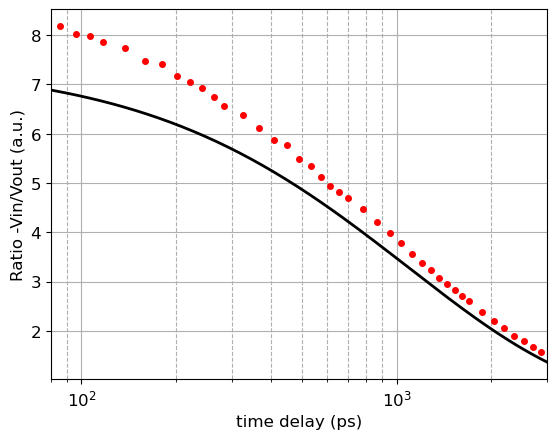

In [ ]:
%%time
Bidirectional.plot()

In [ ]:
%%time
OptRes = Bidirectional.fit(
    method  = 'Nelder-Mead', 
    bounds  = ((0, np.inf), (10, 1000), (0, np.inf)),
    plot    = False, verbose = True,
    fatol = 0.05, xatol = 0.5
)
# OptRes = Bidirectional.least_squares(
#     bounds = (optimize.Bounds(0.01, 1),
#               optimize.Bounds(0.5, 50), 
#               optimize.Bounds(0.01, 1)),
#     plot   = True, verbose = True
# )

Fitted thermal conductivities (W m^-1 K^-1): 
3. AlN: 135.07
Calculated (lambda / h) thermal conductances (MW m^-2 K^-1): 
2. Al/AlN: 181.16
4. AlN/Si: 310.09
CPU times: user 8.1 s, sys: 1 ms, total: 8.1 s
Wall time: 8.12 s


In [ ]:
OptRes

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0011461065560406701
             x: [ 1.812e-01  1.351e+02  3.101e-01]
           nit: 68
          nfev: 115
 final_simplex: (array([[ 1.812e-01,  1.351e+02,  3.101e-01],
                       [ 1.809e-01,  1.355e+02,  3.088e-01],
                       [ 1.812e-01,  1.348e+02,  3.108e-01],
                       [ 1.811e-01,  1.350e+02,  3.097e-01]]), array([ 1.146e-03,  1.146e-03,  1.146e-03,  1.146e-03]))

CPU times: user 78.4 ms, sys: 9 μs, total: 78.4 ms
Wall time: 78.3 ms


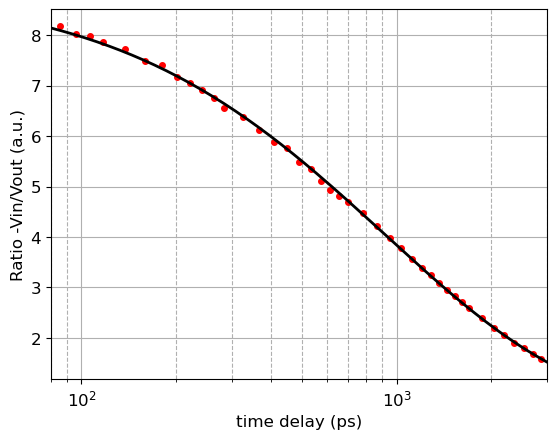

In [ ]:
%%time
Bidirectional.plot()

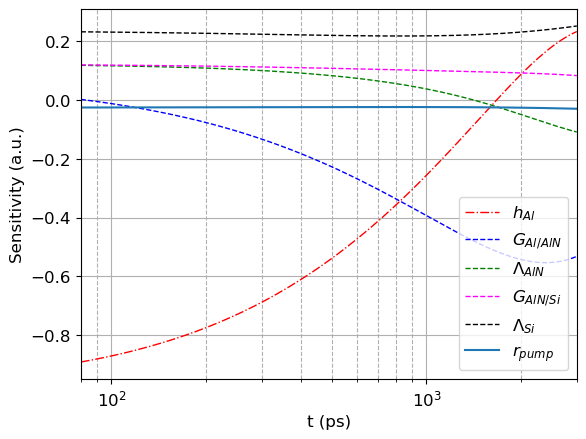

In [ ]:
S, Sx = Bidirectional.calculate_sensitivity()
Bidirectional.plot_sensitivity(S, i_C = [], i_h = [0], i_Lambda = [1, 2, 3, 4], 
                               legend_loc = 'lower right')